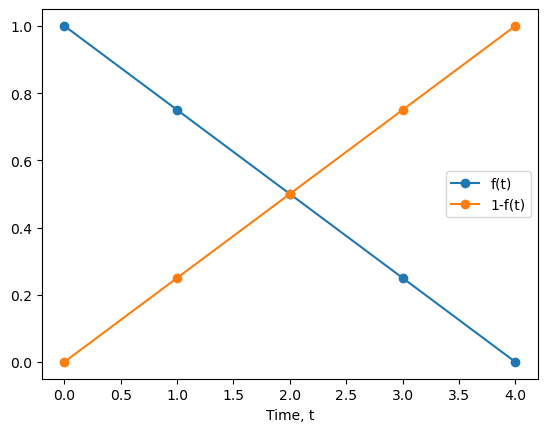

In [1]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.linspace(1,0,5), marker='o', label="f(t)");
plt.plot(np.linspace(0,1,5), marker='o', label="1-f(t)");
plt.xlabel("Time, t");
plt.legend();


# **Question**: 
In the next cell: explain what $\hat{U}^H$ does to the states, ket{0} and ket{1} in terms of $\hat{x}$.:

0 and 1, once passed through the Hadamard become the +/- states, the eigenvalues of X. Thus, they remain in the same state after going through the X. The - (formerly 1) gets an overall phase of -1.

---
For this notebook, we'll use Qiskit, which will need to be installed into your environment:

```
pip install qiskit
pip install qiskit-aer
pip install pylatexenc
```
---

/tmp/ipykernel_191284/2132263217.py:7: DeprecationWarning: The 'qiskit.Aer' entry point is deprecated and will be removed in Qiskit 1.0. You should use 'qiskit_aer.Aer' directly instead.
  sim = Aer.get_backend('statevector_simulator')
/home/firt/miniconda3/envs/molssi_best_practices/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


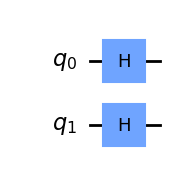

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import *
from qiskit.tools.visualization import plot_histogram
# from qiskit.tools.visualization import plot_bloch_multivector

sim = Aer.get_backend('statevector_simulator')

circ = QuantumCircuit(2,0)
circ.h(0)
circ.h(1)
circ.draw(output = 'mpl')

/tmp/ipykernel_191284/2706169862.py:1: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  plot_histogram(execute(circ, backend = sim).result().get_counts(circ))
/tmp/ipykernel_191284/2706169862.py:1: DeprecationWarning: Using plot_histogram() ``data`` argument with QuasiDistribution, ProbDistribution, or a distribution dictionary is deprecated as of qiskit-terra 0.22.0. It will be removed no earlier than 3 months after the release date. Instead, use ``plot_distribution()``.
  plot_histogram(execute(circ, backend = sim).result().get_counts(circ))


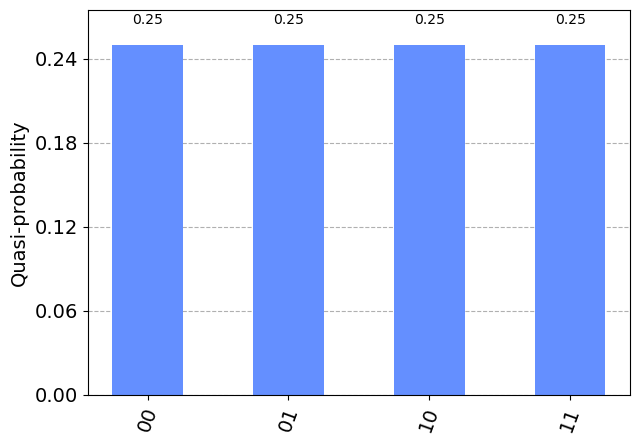

In [3]:
plot_histogram(execute(circ, backend = sim).result().get_counts(circ))

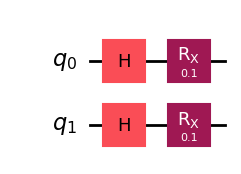

In [4]:
circ = QuantumCircuit(2,0)
circ.h(0)
circ.h(1)
circ.rx(.1,0)
circ.rx(.1,1)
circ.draw(output = 'mpl', style="iqp")

/tmp/ipykernel_191284/2706169862.py:1: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  plot_histogram(execute(circ, backend = sim).result().get_counts(circ))
/tmp/ipykernel_191284/2706169862.py:1: DeprecationWarning: Using plot_histogram() ``data`` argument with QuasiDistribution, ProbDistribution, or a distribution dictionary is deprecated as of qiskit-terra 0.22.0. It will be removed no earlier than 3 months after the release date. Instead, use ``plot_distribution()``.
  plot_histogram(execute(circ, backend = sim).result().get_counts(circ))


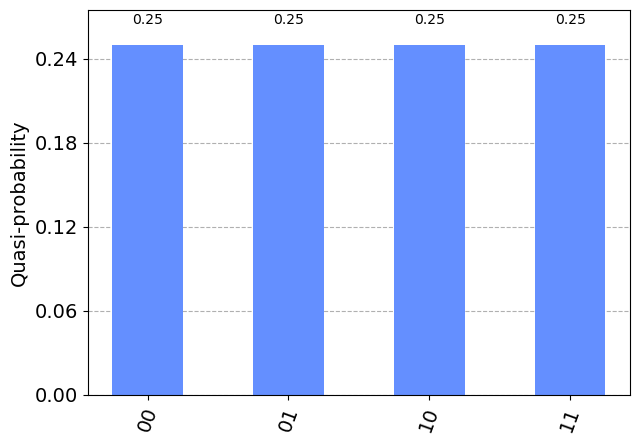

In [5]:
plot_histogram(execute(circ, backend = sim).result().get_counts(circ))

# **Question**: 
Explain why the measured probability stayed the same in the above plot:

We are applying two X gates to two eigenvalues of X (+), so the state and thus the probability doesn't change.

---

## Second time step

Now we must implement the following operator: $e^{-i\left(.75\hat{H}_0 + .25\hat{H}_1\right)\Delta t}$. 

Unfortunately, $\sigma^z\sigma^x \neq \sigma^z\sigma^x$ and so we can't exactly trotterize this. 
However, because $\Delta t \ll 1$, we can approximate this in a product form, and this will become increasingly more accurate as we take smaller time steps. 

$$ \hat{H}_0 = - \sigma^x_0 - \sigma^x_1$$
$$ \hat{H}_1 = J\sigma^z_0\sigma^z_1 + \mu\sigma^z_1 + \mu\sigma^z_1$$

$$
e^{-i\left(- .75\sigma^x_0 - .75\sigma^x_1 + .25 J\sigma^z_0\sigma^z_0 + .25\mu\sigma^z_1 + .25\mu\sigma^z_1\right)\Delta t}
\approx
e^{.75 i\sigma^x_0\Delta t} 
e^{.75 i\sigma^x_1\Delta t}
e^{-.25 i J\sigma^z_0\sigma^z_1 \Delta t}
e^{-.25 i \mu\sigma^z_0 \Delta t}
e^{-.25 i \mu\sigma^z_1 \Delta t}
$$

Notice here that we are using a new gate, `RZZ`. 
This is a 2-qubit gate that rotates about the product of two $\sigma^z$ operators.

/home/firt/miniconda3/envs/molssi_best_practices/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


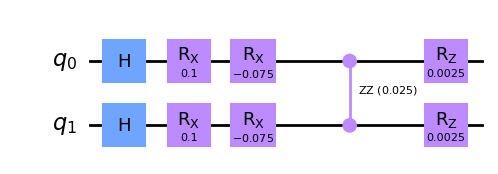

In [6]:
circ = QuantumCircuit(2,0)
# initialize
circ.h(0)
circ.h(1)

# time step 1
circ.rx(.1,0)
circ.rx(.1,1)

# time step 2
circ.rx(-.075,0)
circ.rx(-.075,1)
circ.rzz(.025,0,1)
circ.rz(.0025,0)
circ.rz(.0025,1)

circ.draw(output = 'mpl')

From here we can recognize the pattern and start to generalize with a function!


## Automate the circuit building

Because each step will have the same gates, but different angles, we can simply write a function to create the circuit. 

In [7]:
import montecarlo

def form_circuit(beta, ham: montecarlo.IsingHamiltonian):
    """
    Form the circuit for adiabatic evolution
    
        H = J\sum_{ij} \sigma_i^z \sigma_j^z + \mu\sum_i\sigma_i^z
    """
    # initializing crap stuff
    N = len(ham.J)
    circ = QuantumCircuit(N,0)

    # Initia states
    for i in range(N):
        circ.h(i)
    
    # Loop through time steps
    for b in beta:
        for j in range(N):
            circ.rx(b, j)
        for j in range(len(ham.J)):
            for coupling in ham.J[j]:
                circ.rzz(-coupling[1] * (1 - b), j, coupling[0])
        for j in range(N):
            circ.rz(-ham.mu[j] * (1 - b), j)

    
    return circ
    


## Plot for Arbitrary steps and qubits

Try out different numbers of steps and different Hamiltonians. 
- $\hat{H}(t) = \beta(t)\hat{H}_0 + \gamma(t)\hat{H}_1$

In [8]:
# form Hamiltonian
def build_1d_Hamiltonian(N, Jval, mu=0.0):
    """
    Build a 1D Hamiltonian with a single J value (Jval)
    """
    mus = [0.0 for i in range(N)]
    J = [[] for i in range(N)]
    for site in range(N-1):
        J[site].append((site+1, Jval))
    return montecarlo.IsingHamiltonian(J,mus)

ham = build_1d_Hamiltonian(N=3, Jval=1)

# let's add a local mu value to the first spin
ham.mu[0] = 1.2 

# Testing
print(ham.J[1][0][1])
print(ham.J)


1
[[(1, 1)], [(2, 1)], []]


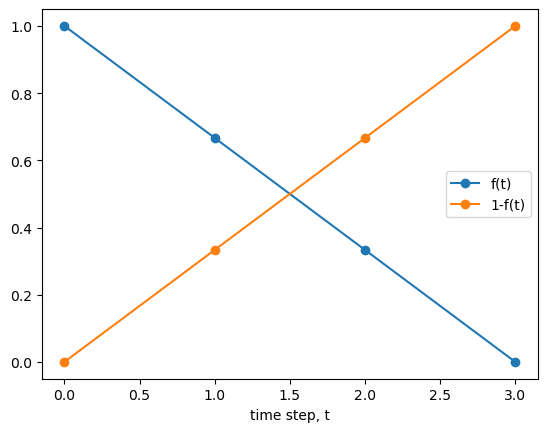

In [9]:
# create the adiabatic parameters
n_steps = 3
beta = []
gamma = []
for i in range(n_steps+1):
    beta.append(1-i/n_steps)
    gamma.append(i/n_steps)

plt.plot(beta, label="f(t)", marker="o")
plt.plot(gamma, label="1-f(t)", marker="o");
plt.xlabel("time step, t")
plt.legend();

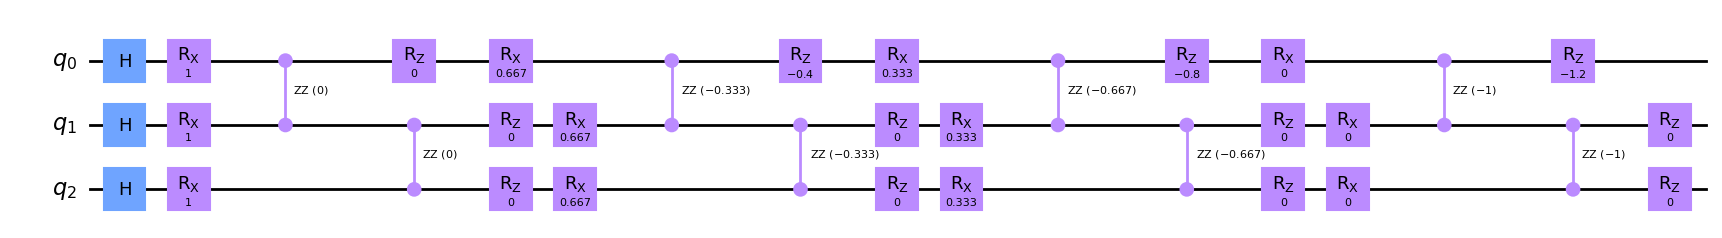

In [10]:
# Create the quantum circuit

circ = form_circuit(beta, ham)
circ.draw(output="mpl")

/tmp/ipykernel_191284/480607385.py:2: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  result_sv = execute(circ, backend = sim).result()
/tmp/ipykernel_191284/480607385.py:4: DeprecationWarning: Using plot_histogram() ``data`` argument with QuasiDistribution, ProbDistribution, or a distribution dictionary is deprecated as of qiskit-terra 0.22.0. It will be removed no earlier than 3 months after the release date. Instead, use ``plot_distribution()``.
  plot_histogram(result_sv.get_counts(circ))


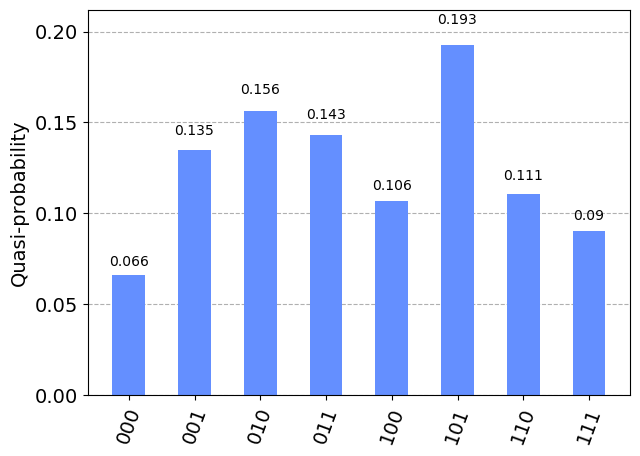

In [11]:
sim = Aer.get_backend('statevector_simulator')
result_sv = execute(circ, backend = sim).result()
state_vec = result_sv.get_statevector()
plot_histogram(result_sv.get_counts(circ))

In [12]:
samples = result_sv.get_counts(circ)
max(samples, key=samples.get)

'101'

In [13]:
# Let's check to see that our answers are correct, by computing them directly (using adding the code you wrote in graph_energy.ipynb to your package)
emin, cmin = ham.get_lowest_energy_config(verbose=1)
print(" Energy minimum = %12.8f %s"%(emin, cmin))

 Energy minimum =  -3.20000000 010


# **Question**: 
What are the probabilities for measuring the correct bitstring using the following number of time steps (i.e., values of `n_steps`):
1.  `n_steps` = 2
1.  `n_steps` = 4
1.  `n_steps` = 8
1.  `n_steps` = 10 

1. 2 steps   ->    0.125
2. 4 steps   ->    0.287
3. 8 steps   ->    0.524
4. 10 steps  ->    0.627